In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import jax
from jax import grad, jit
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from utils import *

### 1d VBMC

In [2]:
def expensive_log_likelihood(obs, params, weights=None):
    mu_params = params[0]
    s_params = params[1]

    mu_params = jnp.array(mu_params)
    s_params = jnp.array(s_params)
    n_components = len(mu_params)

    #assume equal weights
    if weights is None:
        weights = jnp.ones(n_components)/n_components
    else:
        weights = jnp.array(weights)/jnp.sum(weights)

    t1 = 1.0/(jnp.sqrt(2*jnp.pi)*s_params)
    t2 = jnp.exp(-0.5*((obs - mu_params)/s_params)**2)
    terms = t1*t2

    likelihood = jnp.sum(weights*terms, axis=1)
    log_likelihood = jnp.log(likelihood + 1e-12)
    return log_likelihood



def expensive_log_likelihood(obs, params, weights=None):
    obs = jnp.array(obs).reshape(-1, 1)
    params = jnp.array(params)
    
    mu_params = params[0]          # triangle peaks
    width_params = jnp.exp(params[1])
    n_components = len(mu_params)
    
    if weights is None:
        weights = jnp.ones(n_components)/n_components
    else:
        weights = jnp.array(weights)
        weights = weights / jnp.sum(weights)
    
    def tri_pdf(x, mu, w):
        left = mu - w
        right = mu + w
        slope_up = 1.0 / w
        slope_down = -1.0 / w
        return jnp.where((x >= left) & (x <= mu), slope_up*(x - left),
               jnp.where((x > mu) & (x <= right), slope_down*(x - mu) + 1.0, 0.0))
    
    pdf_vals = jnp.stack([weights[i]*tri_pdf(obs, mu_params[i], width_params[i])
                          for i in range(n_components)], axis=1)
    
    likelihood = jnp.sum(pdf_vals, axis=1)
    log_likelihood = jnp.log(likelihood + 1e-12).ravel()
    return log_likelihood


Optimised params: [10.6013258   1.92577712]
Optimised log marginal likelihood: -118.68692716667856


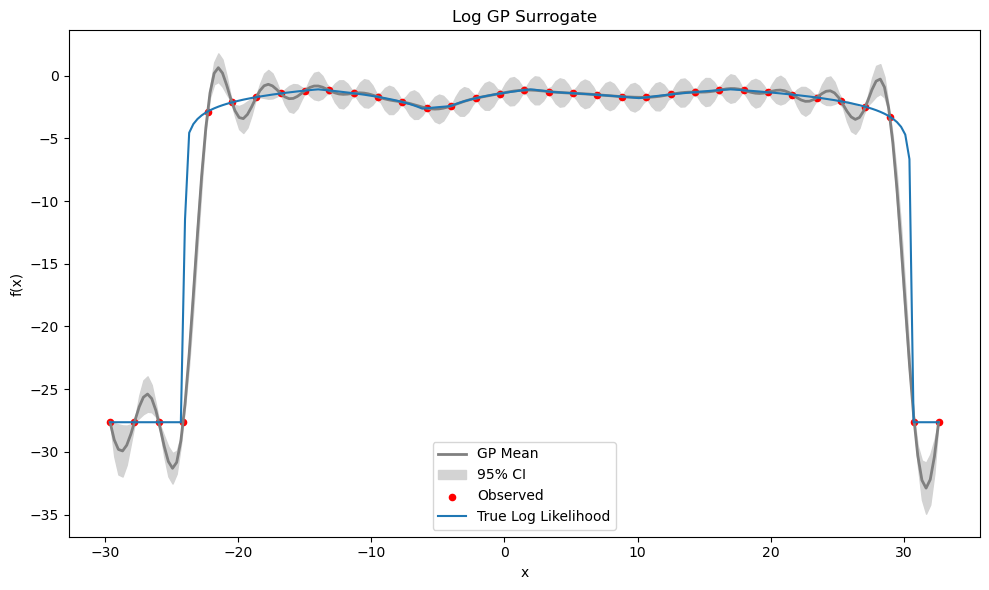

In [3]:
n = 35
mu_true = jnp.array([-14, 2, 17])
s_true = jnp.array([2.3, 2.1, 2.6])
params_true = jnp.array([mu_true, s_true])
lower = min(mu_true) - 6*max(s_true)
upper = max(mu_true) + 6*max(s_true)




x = jnp.linspace(lower,upper,n).reshape(-1, 1)
y = expensive_log_likelihood(x, params_true)

grad_fn = grad(neg_gp_likelihood)
s_init = 5
l_init = jnp.array([20])
init_params = jnp.concatenate([jnp.array([s_init]), l_init])

res = minimize(
    fun=lambda p: float(neg_gp_likelihood(p, x, y, rbf)),
    x0=init_params,
    jac=lambda p: jnp.array(grad_fn(p, x, y, rbf)),
    method="L-BFGS-B",
    bounds=[(1, 20)]*len(init_params)
)

#kernel hyperparameters
s = res.x[0]
L = jnp.diag(res.x[1:])
print("Optimised params:", res.x)
print("Optimised log marginal likelihood:", -res.fun)

x_eval = jnp.linspace(lower,upper,200)
mu_eval,var_eval = gp_predict(x,y,x_eval,kernel=rbf,s=s,L=L)
sig_diag = jnp.sqrt(np.diag(var_eval))

#plot gp
plt.figure(figsize=(10, 6))

plt.plot(x_eval, mu_eval, lw=2, color='gray', label='GP Mean')
plt.fill_between(x_eval.ravel(),
                mu_eval.ravel() - 2*sig_diag.ravel(),
                mu_eval.ravel() + 2*sig_diag.ravel(),
                color='lightgray', label='95% CI')


plt.scatter(x, y, c='red', s=20, label='Observed')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Log GP Surrogate")
plt.legend(loc='upper left')
plt.tight_layout()


x_vals = jnp.linspace(lower, upper, 200).reshape(-1,1)
log_likelihood = expensive_log_likelihood(x_vals, params_true)

plt.plot(x_vals, log_likelihood, label='True Log Likelihood')
#plt.ylim(-10,0)
plt.legend()
plt.show()

### Find variational posterior

$$
\log p(\mathbf{x}) = \underbrace{\mathbb{E}_q[\log p(\mathbf{z},\mathbf{x})] - \mathbb{E}_q[\log q(\mathbf{z})]}_{= ELBO} + \underbrace{\text{KL}(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x}))}_{\ge 0}
$$

$$
\text{ELBO} = \underbrace{\mathbb{E}_q[\log p(\mathbf{z},\mathbf{x})]}_{=\text{Expected Log Joint}} + \underbrace{\left(-\mathbb{E}_q[\log q(\mathbf{z})]\right)}_{=\text{Entropy of Q}}
$$


 In this example, the expensive likelihood function $p(\mathbf{z}|\mathbf{x}) = p(\mathbf{x},\mathbf{z})$.

 - $\mathbb{E}_q[\log p(\mathbf{z},\mathbf{x})] = \mathbb{E}_q[\log p(\mathbf{z}|\mathbf{x})]$
 - Maximum $\text{ELBO}$ occurs when $\text{KL}(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x})) = 0 \implies q(\mathbf{z}) = p(\mathbf{z}|\mathbf{x})$
 - This makes $\mathbb{E}_q[\log p(\mathbf{z}|\mathbf{x})]$ the negative entropy of Q.
 - This makes the maximum $\text{ELBO} = 0$ 


 Another way to see this is since $p(\mathbf{x},\mathbf{z}) = p(\mathbf{z}|\mathbf{x})p(\mathbf{x})$
 - Maximum $\text{ELBO}$ occurs when $\text{KL}(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x})) = 0$ 
 - $\implies \log p(\mathbf{x}) = \text{ELBO} + \underbrace{\text{KL}(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x}))}_{= 0} = 0$ since $p(\mathbf{x}) = 1$   



Iter 1, 10000: ELBO = 2.0788604988272903
Iter 1, 20000: ELBO = 2.161232407810762
Iter 2, 10000: ELBO = 2.2030964155991564
Iter 2, 20000: ELBO = 2.228062686106262
Iter 3, 10000: ELBO = 2.243375489652698
Iter 3, 20000: ELBO = 2.2625344077026033
Iter 4, 10000: ELBO = 2.2753731684301135
Iter 4, 20000: ELBO = 2.285710748023591
Iter 5, 10000: ELBO = 2.2875265622085865
Iter 5, 20000: ELBO = 2.2923339499655353

Best ELBO 2.2923339499655353
Parameter     Optimized         True
------------------------------------
mu1            -13.8100     -14.0000
mu2              2.3318       2.0000
mu3             16.9438      17.0000
sigma1           3.3279       2.3000
sigma2           4.6313       2.1000
sigma3           4.4269       2.6000


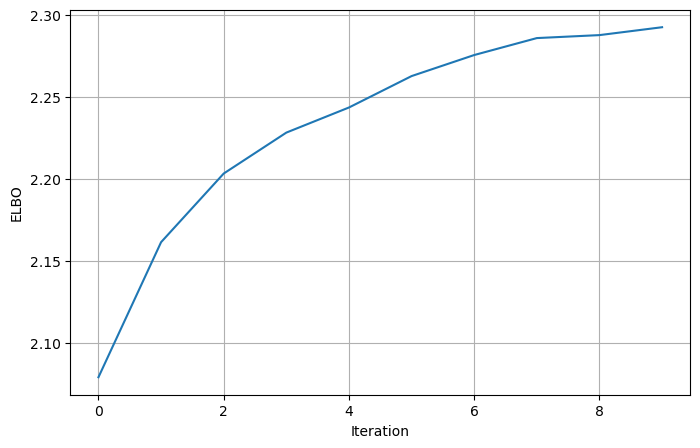

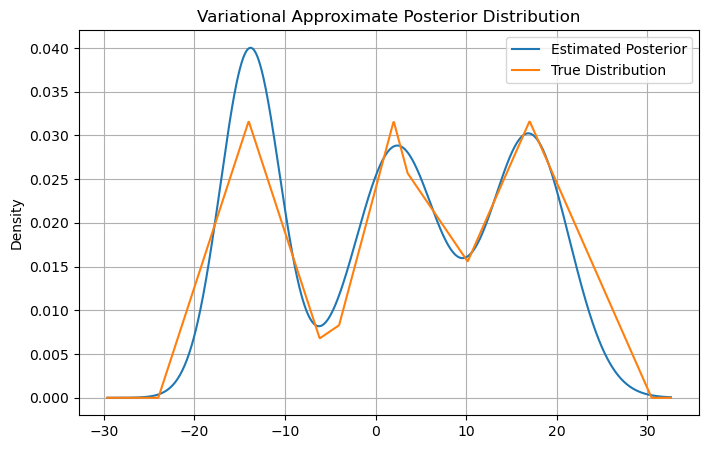

In [4]:
mu_initial = jnp.array([-9,-2,9.5])
s_initial = jnp.array([1,2,1])
params = jnp.array([mu_initial, jnp.log(s_initial)])
grad_elbo = jit(grad(elbo))
key = jax.random.PRNGKey(0)
params, best_elbo, elbo_history = vbmc1(x,y,params,grad_elbo,s,L,
                                        lr=0.005, n1=5, n2=20_000, key=key)


n_components = len(mu_initial)
mu_opt = params[0]
s_opt = jnp.exp(params[1]) 

# Create names dynamically
param_names = [f"mu{i+1}" for i in range(n_components)] + \
              [f"sigma{i+1}" for i in range(n_components)]

# Combine optimized and true values
optimized_vals = jnp.concatenate([mu_opt, s_opt]).flatten()
true_vals = jnp.concatenate([jnp.array(mu_true), jnp.array(s_true)]).flatten()

# Print results neatly
print()
print("Best ELBO", best_elbo)
print(f"{'Parameter':<10} {'Optimized':>12} {'True':>12}")
print("-"*36)
for name, opt, true in zip(param_names, optimized_vals, true_vals):
    print(f"{name:<10} {float(opt):12.4f} {float(true):12.4f}")

# Plot ELBO history
plt.figure(figsize=(8,5))
plt.plot(elbo_history)
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.show()


#plot range
x_min = lower
x_max = upper
x_vals = jnp.linspace(x_min, x_max, 1000).reshape(-1,1)

#estimated mixture PDF
pdf_vals = jax.vmap(lambda x: mixture_pdf(x, mu_params=mu_opt, s_params=s_opt))(x_vals)

#true pdf
true_vals = jnp.exp(expensive_log_likelihood(x_vals, params_true))
true_vals /= jnp.trapezoid(true_vals, x_vals.ravel())

#compare estimated and true distributions
plt.figure(figsize=(8,5))
plt.plot(x_vals, pdf_vals, label='Estimated Posterior')
plt.plot(x_vals, true_vals, label='True Distribution')
plt.title('Variational Approximate Posterior Distribution')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

Iter 1, 15000: ELBO = 0.8826233247215054
Iter 1, 30000: ELBO = 0.8937208219608745


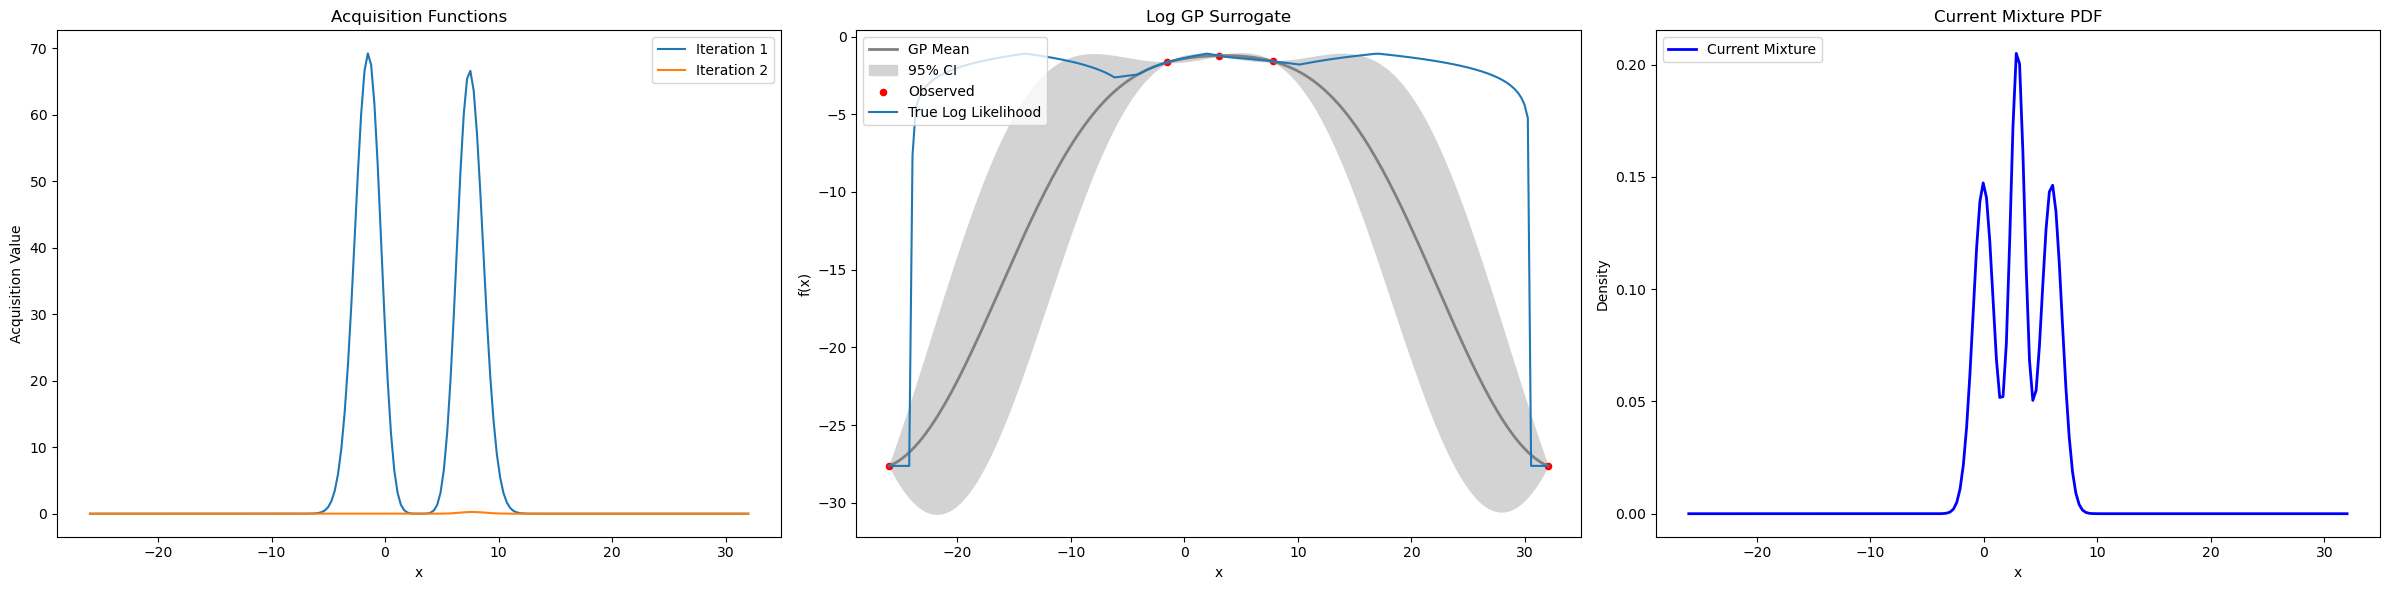

Iter 2, 15000: ELBO = 1.2423789192907444
Iter 2, 30000: ELBO = 1.243005880905785


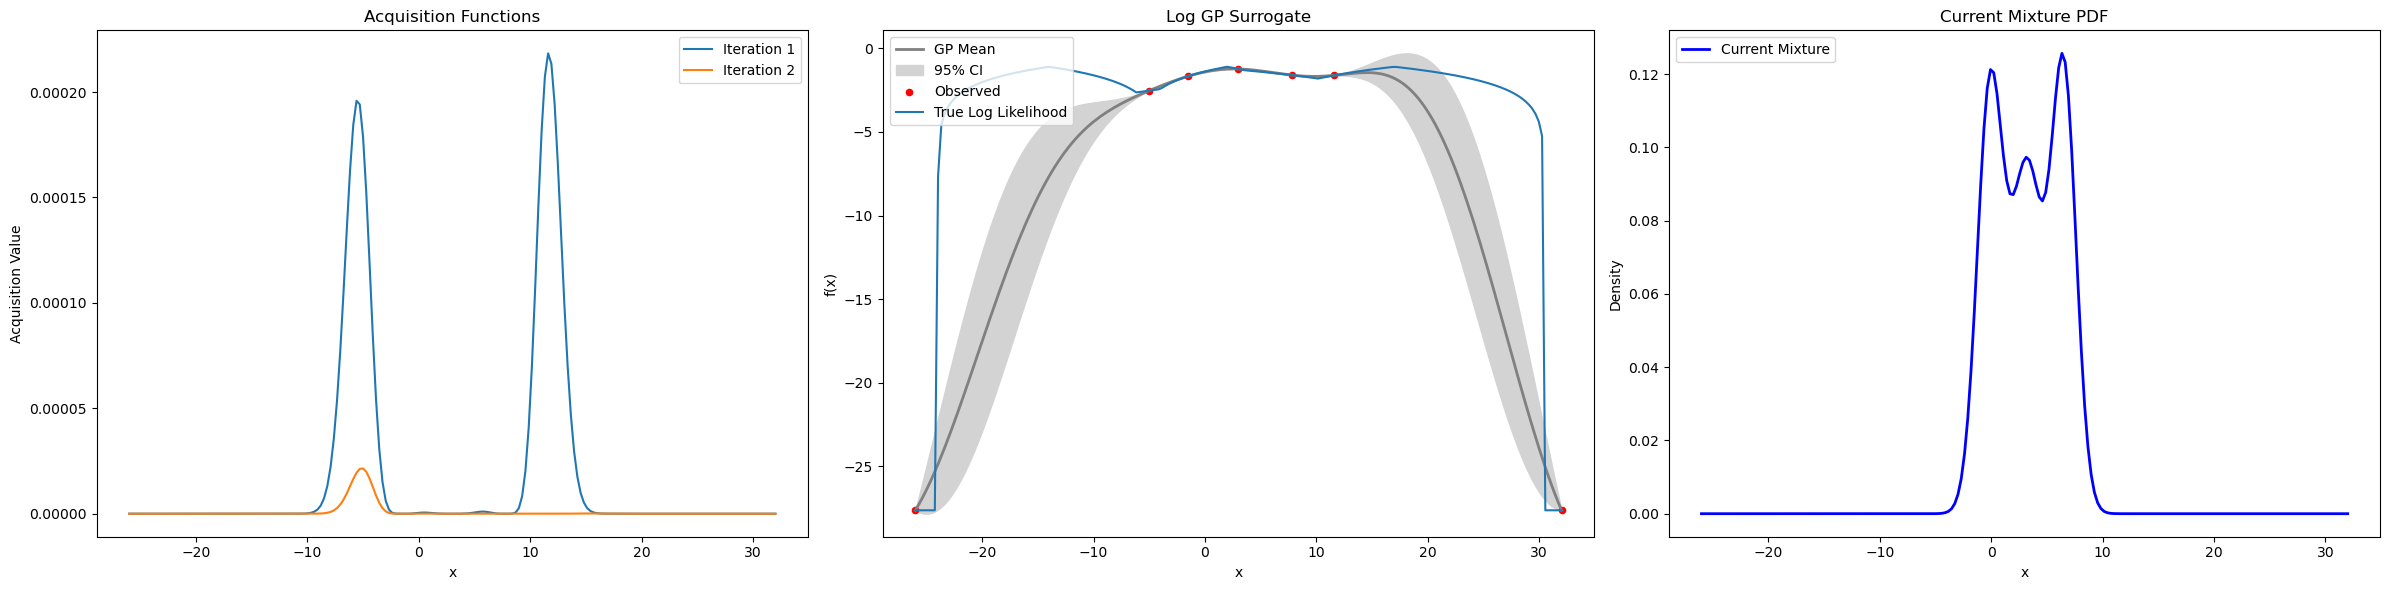

Iter 3, 15000: ELBO = 1.5655685196069333
Iter 3, 30000: ELBO = 1.5820025611123463


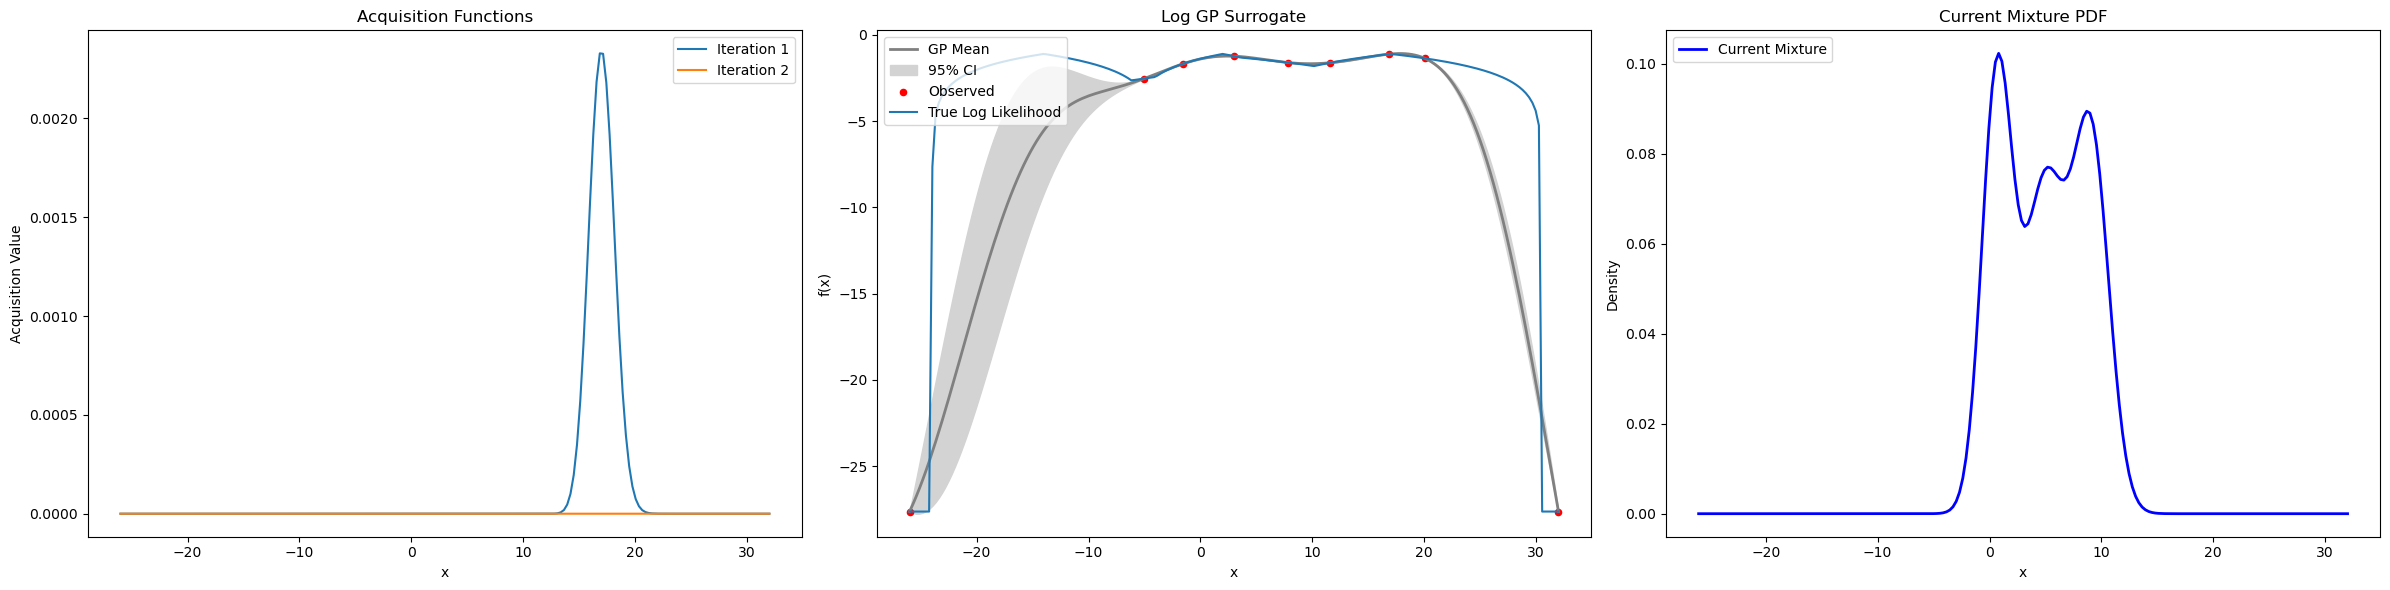

Iter 4, 15000: ELBO = 1.7405049154387122
Iter 4, 30000: ELBO = 1.7780425851615118


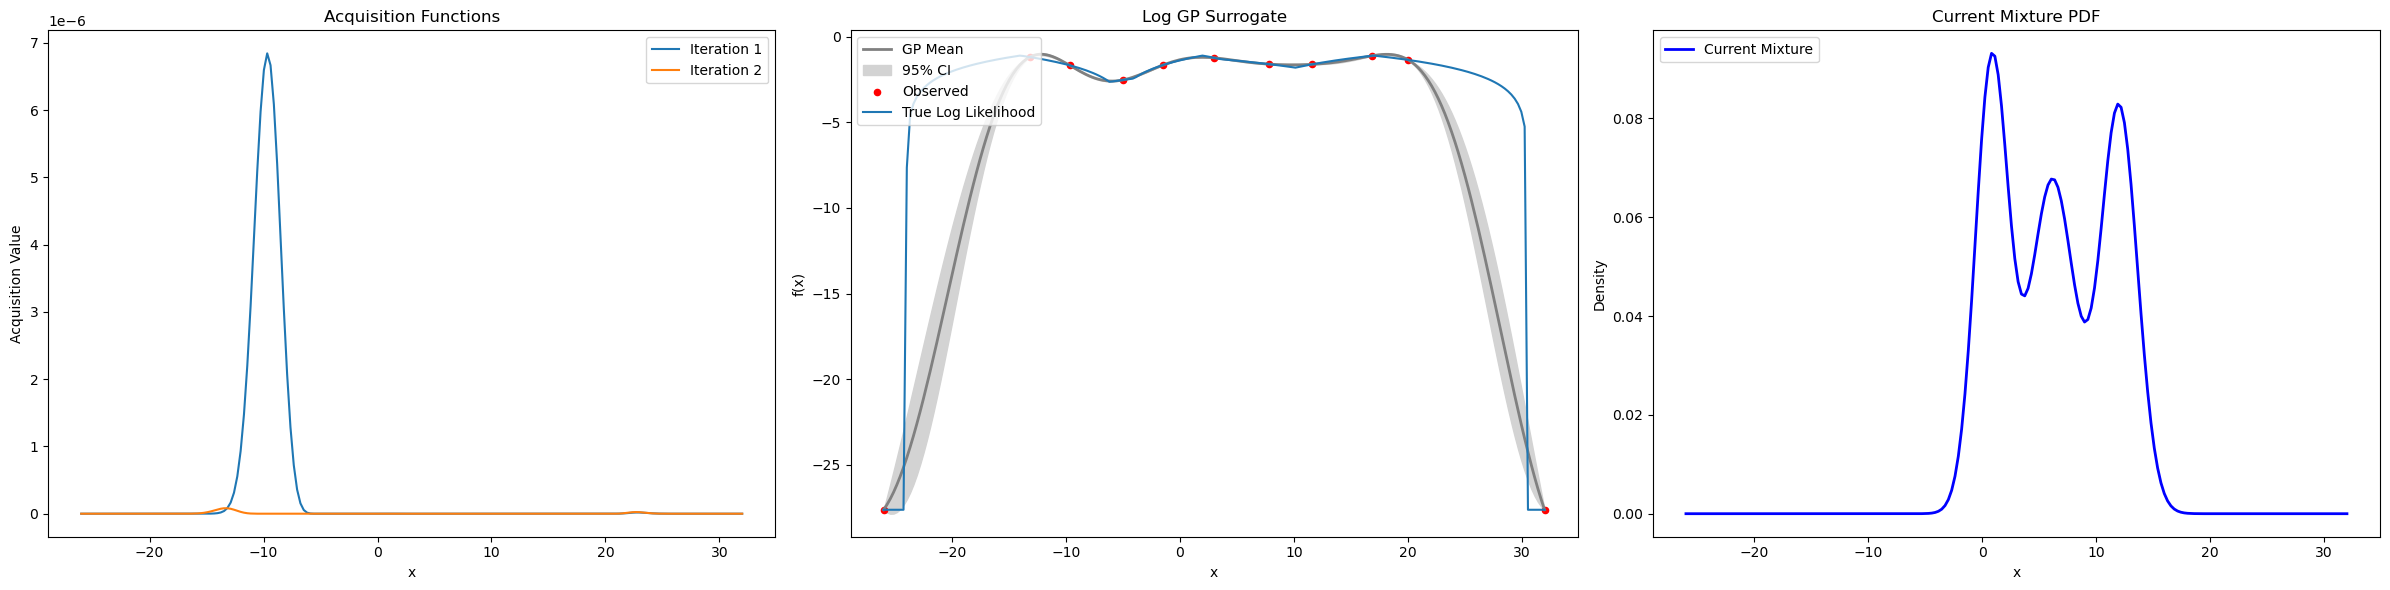

Iter 5, 15000: ELBO = 1.8731962458596652
Iter 5, 30000: ELBO = 1.9147987640228268


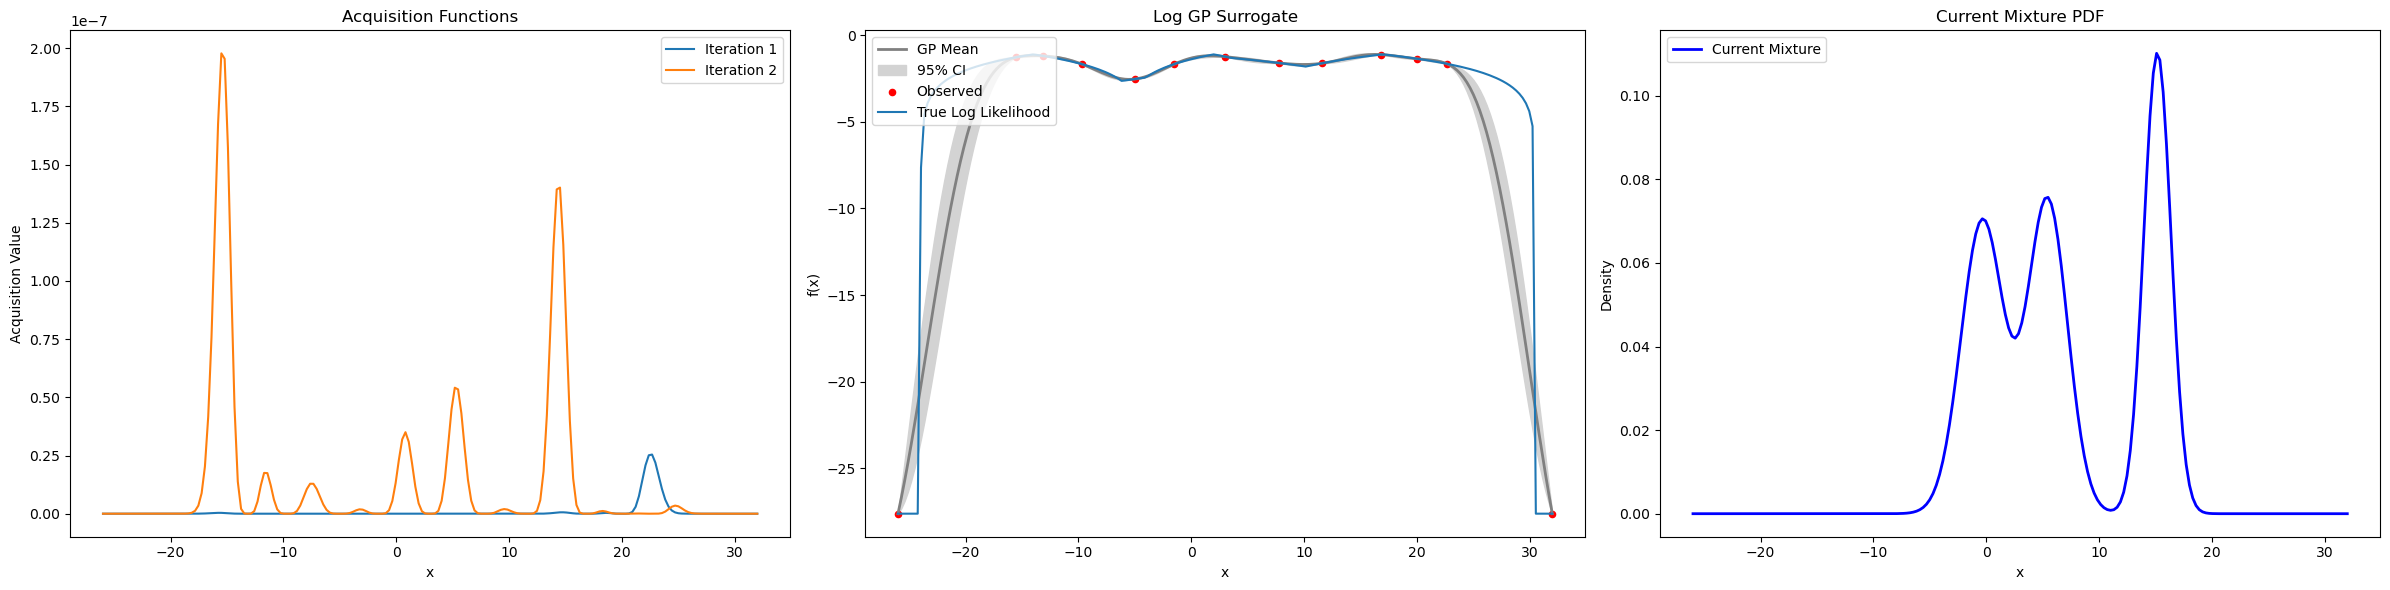

Iter 6, 15000: ELBO = 2.0564300703300264
Iter 6, 30000: ELBO = 2.0656838777909847


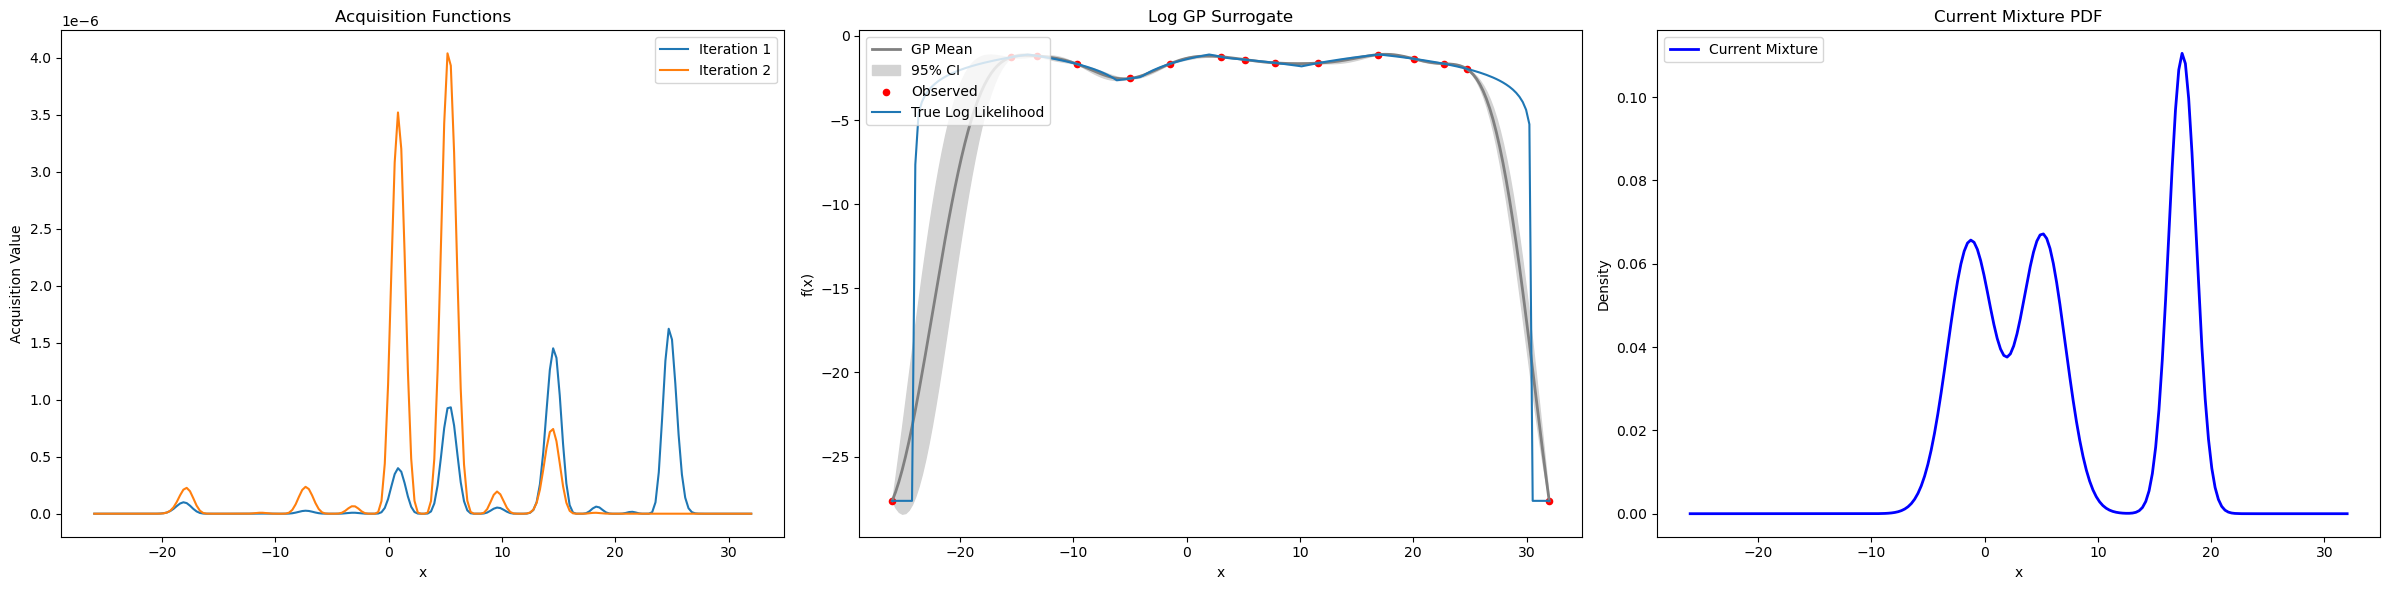

Iter 7, 15000: ELBO = 2.0722134572717392
Iter 7, 30000: ELBO = 2.076761725401182


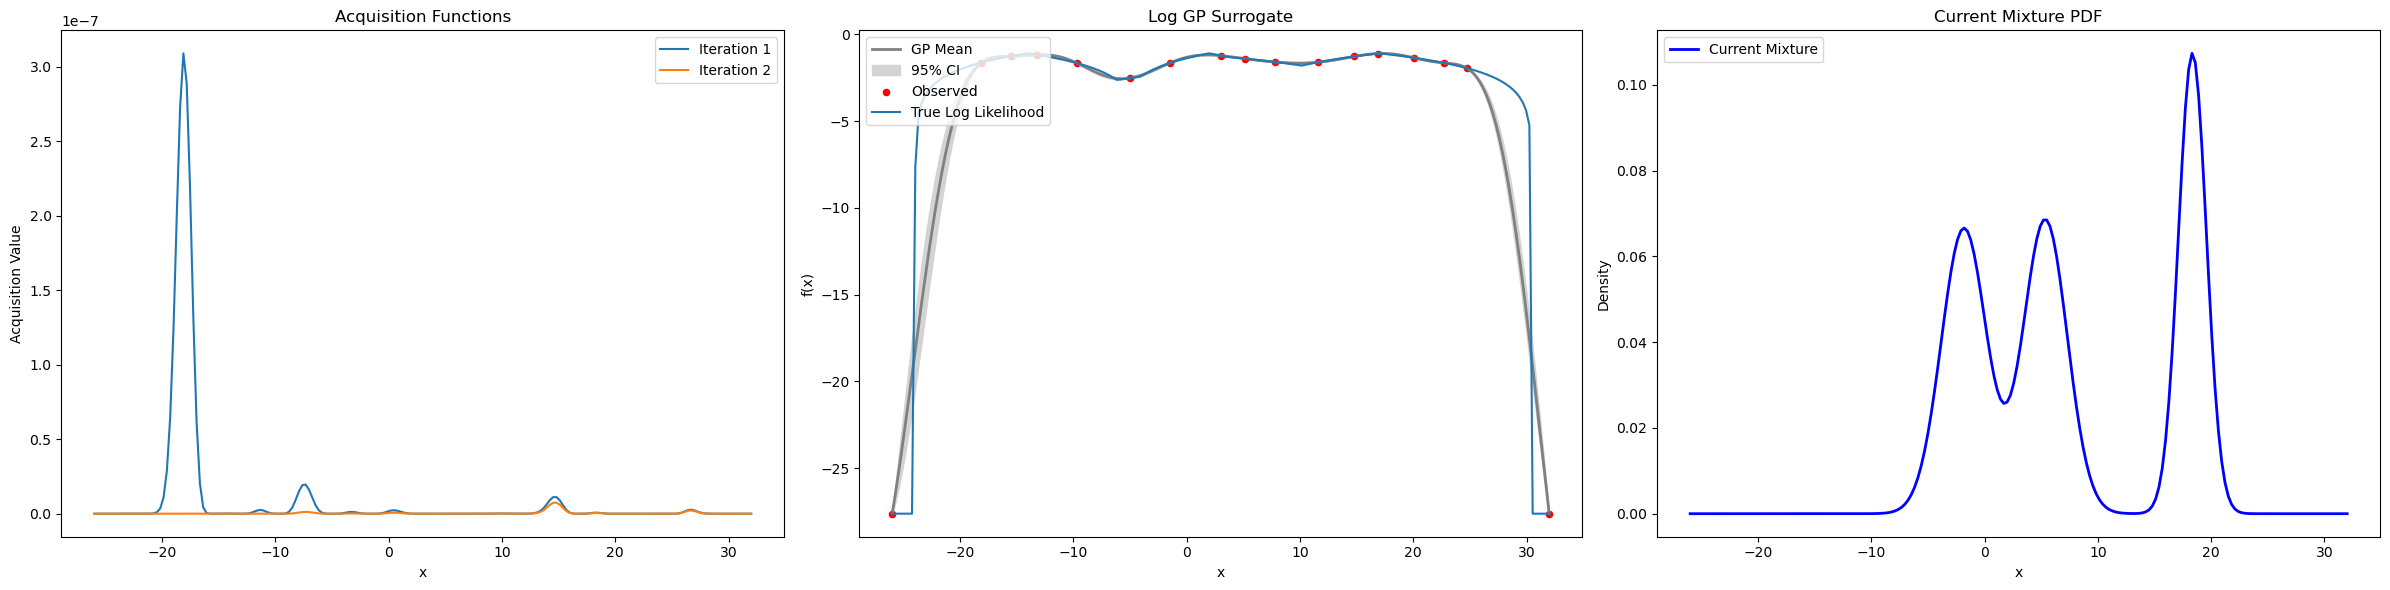

Iter 8, 15000: ELBO = 2.103781523750569
Iter 8, 30000: ELBO = 2.1120459109574337


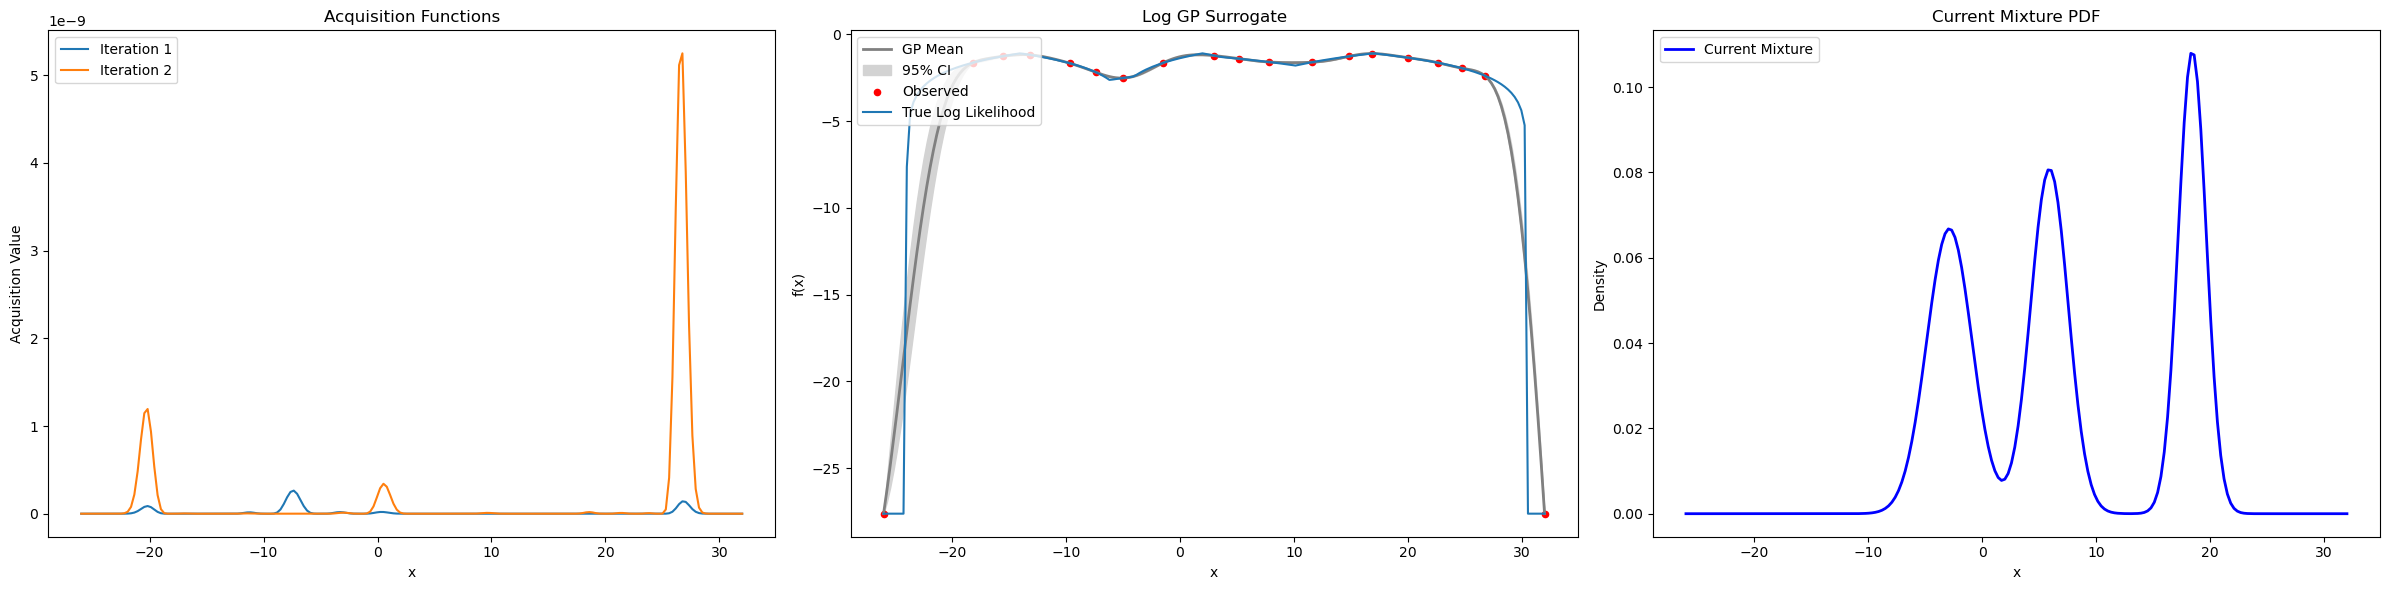

Iter 9, 15000: ELBO = 2.1403771876695523
Iter 9, 30000: ELBO = 2.1459908271357593


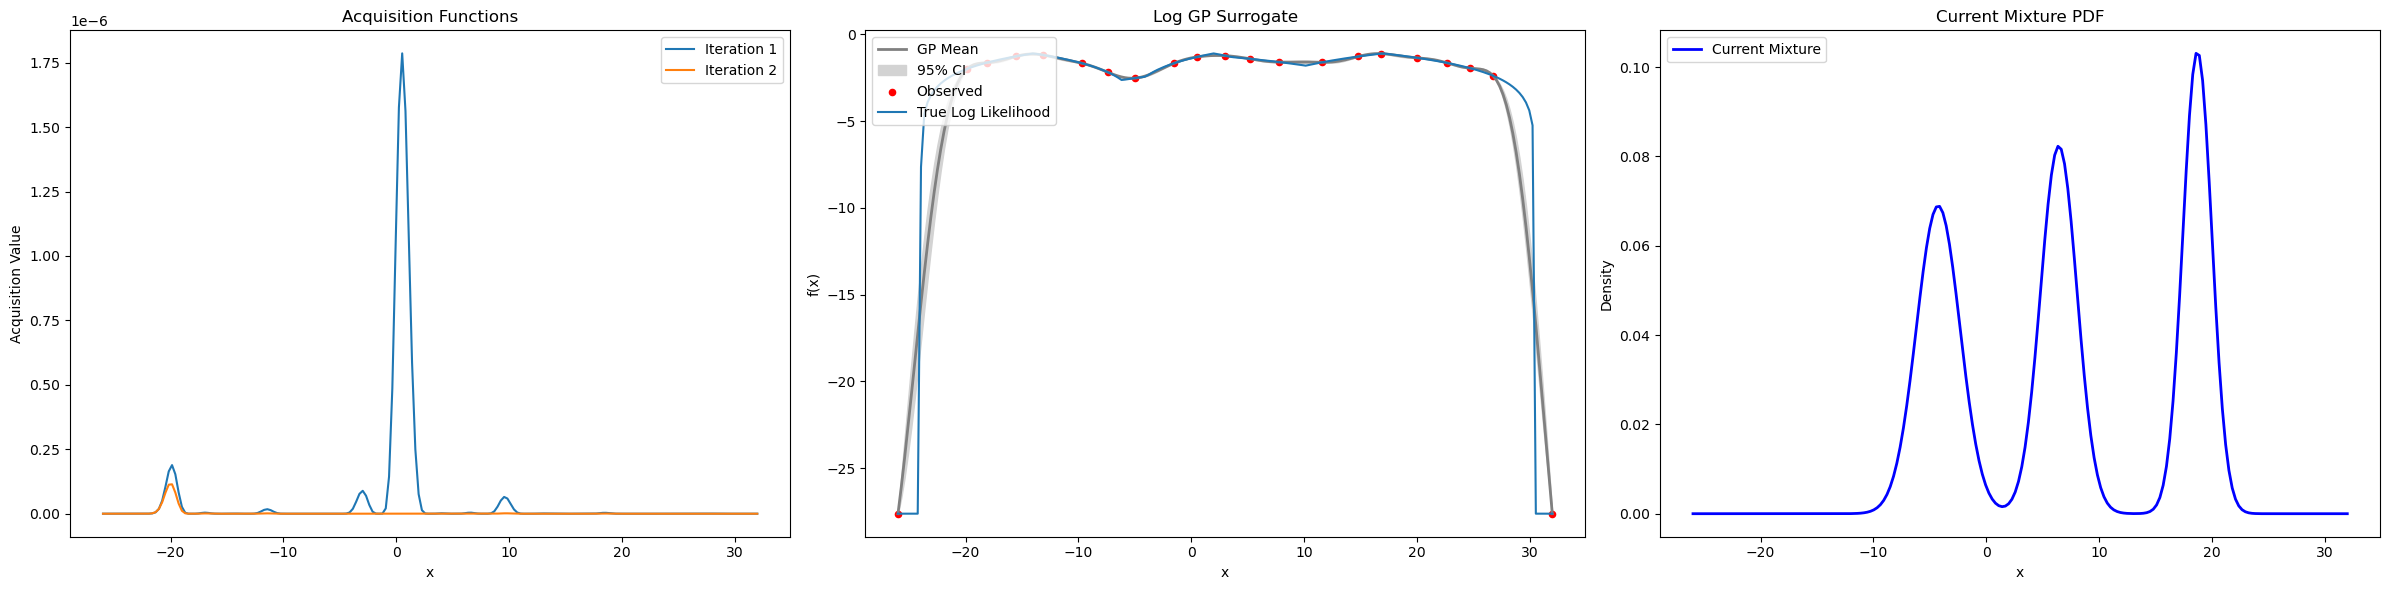

Iter 10, 15000: ELBO = 2.160186277305313
Iter 10, 30000: ELBO = 2.1691489118107596


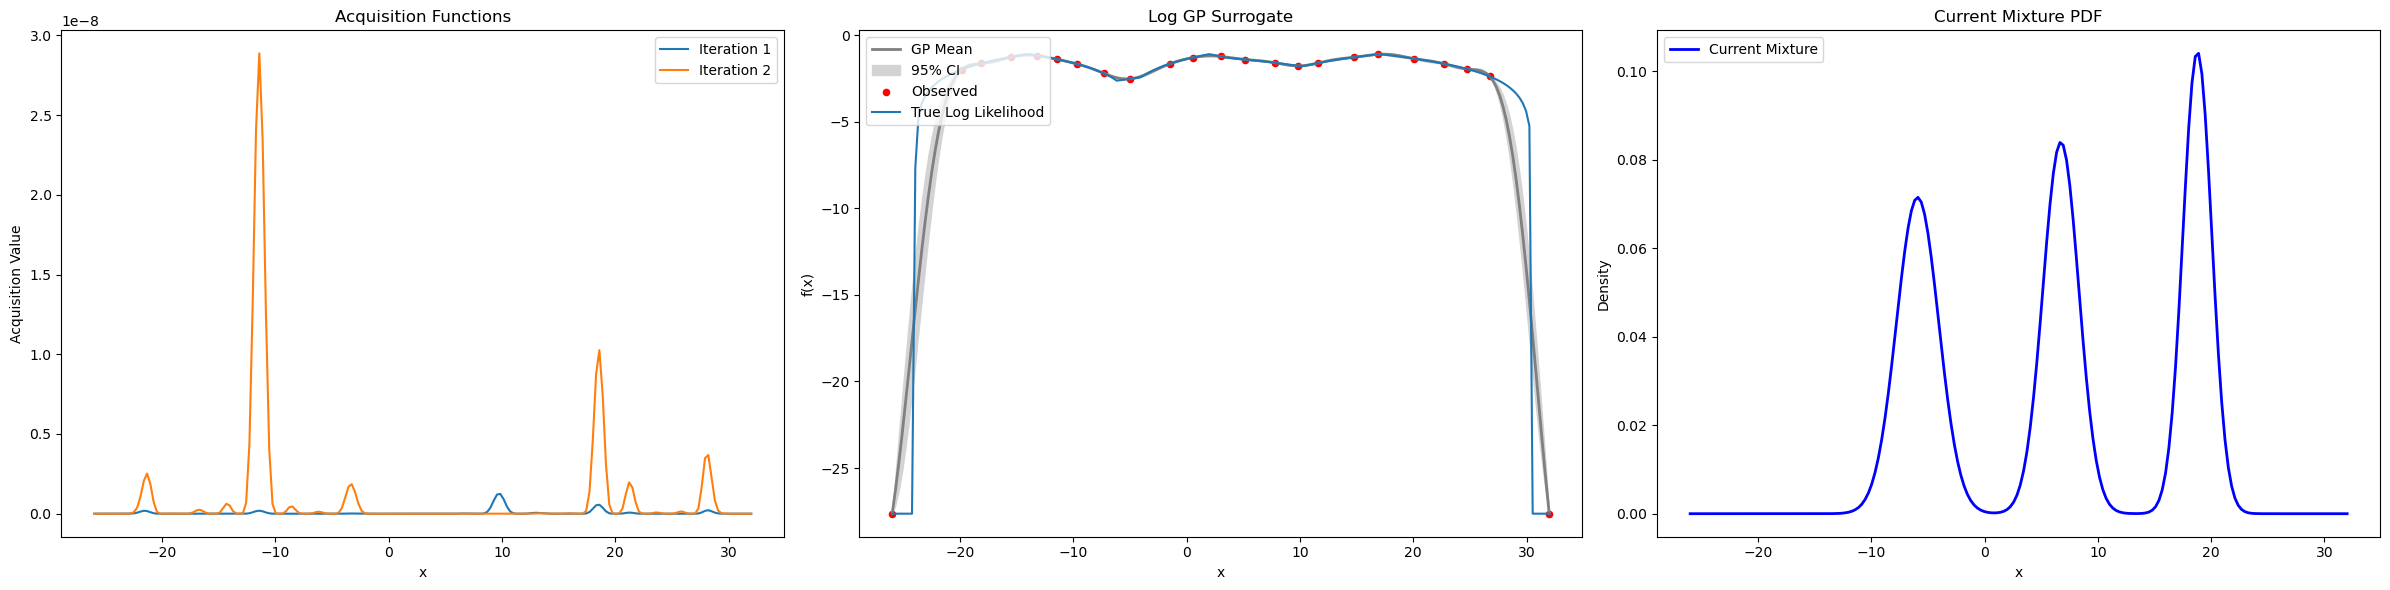


Best ELBO 2.1691489118107596
Parameter     Optimized         True
------------------------------------
mu1             -5.9216     -14.0000
mu2              6.7267       2.0000
mu3             18.7770      17.0000
sigma1           6.4262       2.3000
sigma2           4.8716       2.1000
sigma3           3.5753       2.6000


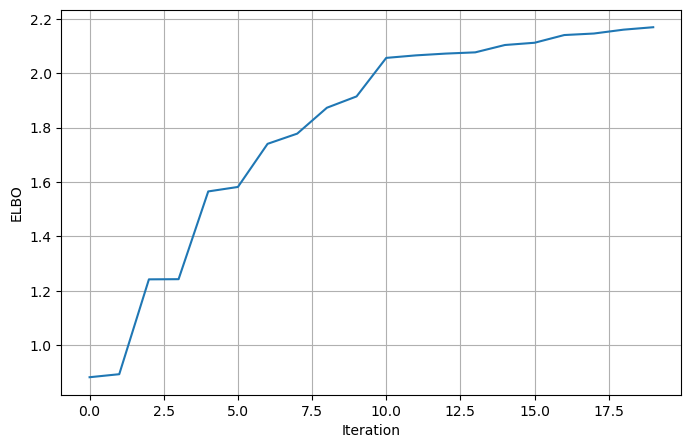

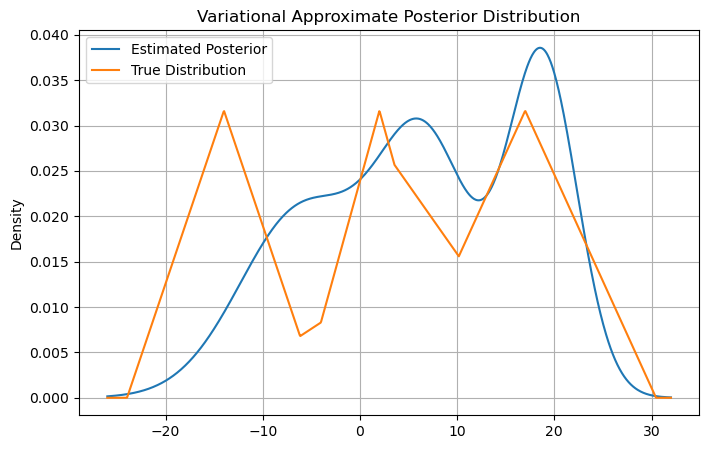

In [294]:
#initial values
mu_initial = jnp.array([-10,-1,9])
s_initial = jnp.array([6,1,3])
params = jnp.array([mu_initial, jnp.log(s_initial)])
x_eval = jnp.linspace(lower,upper,200)
grad_elbo = jit(grad(elbo))
key = jax.random.PRNGKey(0)


params, best_elbo, elbo_history = vbmc2(x,y,params,grad_elbo,s,L,
                                        alpha=2.5, beta=0.3, gamma=1.3,
                                        lr=0.005, n_points=2,n1= 10,
                                        n2=30_000, plots=True,
                                        real_log_likelihood=log_likelihood, 
                                        key=key)

n_components = len(mu_initial)
mu_opt = params[0]
s_opt = jnp.exp(params[1]) 

# Create names dynamically
param_names = [f"mu{i+1}" for i in range(n_components)] + \
              [f"sigma{i+1}" for i in range(n_components)]

# Combine optimized and true values
optimized_vals = jnp.concatenate([mu_opt, s_opt]).flatten()
true_vals = jnp.concatenate([jnp.array(mu_true), jnp.array(s_true)]).flatten()

# Print results neatly
print()
print("Best ELBO", best_elbo)
print(f"{'Parameter':<10} {'Optimized':>12} {'True':>12}")
print("-"*36)
for name, opt, true in zip(param_names, optimized_vals, true_vals):
    print(f"{name:<10} {float(opt):12.4f} {float(true):12.4f}")

# Plot ELBO history
plt.figure(figsize=(8,5))
plt.plot(elbo_history)
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.show()


#plot range
x_min = lower
x_max = upper
x_vals = jnp.linspace(x_min, x_max, 1000).reshape(-1,1)

#estimated mixture PDF
pdf_vals = jax.vmap(lambda x: mixture_pdf(x, mu_params=mu_opt, s_params=s_opt))(x_vals)

#true pdf
true_vals = jnp.exp(expensive_log_likelihood(x_vals, params_true))
true_vals /= jnp.trapezoid(true_vals, x_vals.ravel())

#compare estimated and true distributions
plt.figure(figsize=(8,5))
plt.plot(x_vals, pdf_vals, label='Estimated Posterior')
plt.plot(x_vals, true_vals, label='True Distribution')
plt.title('Variational Approximate Posterior Distribution')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()